This file contains the code for analysis of singular values and U V. 

The analysis follows Fei on Feb 19, 2023

From now (Mar 16, 2023) on, I will take absolute for both weights  and U. 


**Heads-up**

1. When put two grps together, Ctrl first then AD.

In [1]:
# import my own functions
import sys
sys.path.append("../../mypkg")
import importlib

# paras
import paras
from paras import paras

# some useful constants
import constants
importlib.reload(constants)
from constants import REGION_NAMES, REGION_NAMES_WLOBE, DATA_ROOT, RES_ROOT, FIG_ROOT


In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from pathlib import Path
from scipy.io import loadmat
from pprint import pprint
from tqdm import trange, tqdm
from scipy.stats import ttest_ind, mannwhitneyu
from collections import defaultdict as ddict
from easydict import EasyDict as edict
from collections import Counter

# chord plot
# import holoviews as hv
# from holoviews import opts, dim
# hv.extension('matplotlib')
# hv.output(size=300, dpi=100)

%matplotlib inline
plt.style.use(FIG_ROOT/"base.mplstyle")

In [3]:
from utils.matrix import eig_sorted
from utils.misc import paras2name, cumsum_cutoff, load_pkl_folder2dict, save_pkl_dict2folder
from utils.standardize import minmax, minmax_mat, minmax_pn

## Load data

In [4]:
# this parameters only for this file
_paras = edict()
_paras.folder_name = "method8"

In [126]:
# load results
cur_res = load_pkl_folder2dict(RES_ROOT/_paras.folder_name, excluding=["Amat*", "can*"])

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/CPDresult.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ADs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ADs_selected.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ctrls.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ctrls_selected.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/dXXmats_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/dXXmats_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/dwells_ADs_selected.pkl
Load file /data/rajlab1/

## Analysis

In [6]:
# pool all singular vals together and remove sign (Mar 16, 2023)
sing_vals_ADs_pool = np.abs(np.concatenate(cur_res.singular_vals_ADs, axis=1).T)
sing_vals_ctrls_pool = np.abs(np.concatenate(cur_res.singular_vals_ctrls, axis=1).T)
sing_vals_both_pool = np.abs(np.concatenate([sing_vals_ctrls_pool, sing_vals_ADs_pool], axis=0))

In [7]:
# must remove the sign (Mar 16, 2023) and scale of the singular values
sing_vals_ADs_pool_normed = (np.abs(sing_vals_ADs_pool)
                             /np.linalg.norm(sing_vals_ADs_pool, axis=1, ord=2)[:, np.newaxis])
sing_vals_ctrls_pool_normed = (np.abs(sing_vals_ctrls_pool)
                               /np.linalg.norm(sing_vals_ctrls_pool, axis=1, ord=2)[:, np.newaxis])
sing_vals_both_pool_normed = (np.abs(sing_vals_both_pool)
                              /np.linalg.norm(sing_vals_both_pool, axis=1, ord=2)[:, np.newaxis])

### clustering

In [8]:
from rpy2 import robjects as robj
from rpy2.robjects import numpy2ri
numpy2ri.activate()
r = robj.r

In [44]:
# another R pkg to choose the num of clusters (I do not need it currently Mar 22, 2023)
r.library("clusterSim")
index_KL = r["index.KL"]
index_H = r["index.H"]

X = sing_vals_both_pool_normed
n_clu_range = list(range(1, 17))
labss_both = []
for cur_n_clus in n_clu_range:
    if cur_n_clus == 1:
        labs_both = np.zeros(X.shape[0], dtype=int)
    else:
        clus = SpectralClustering(n_clusters=cur_n_clus, random_state=0).fit(X)
        #clus = KMeans(n_clusters=cur_n_clus, random_state=0).fit(X)
        labs_both = clus.labels_
    labss_both.append(labs_both)
    
index_vals = []
for ix, cur_n_clus in enumerate(n_clu_range[:-1]):
    if ix == 0:
        continue
    clall = np.array(labss_both[(ix-1):(ix+2)]).T + 1
    index_val = index_KL(X, clall, centrotypes="centroids")
    index_vals.append(index_val)
    
plt.plot(n_clu_range[1:-1], index_vals)

Text(0, 0.5, 'KL index')

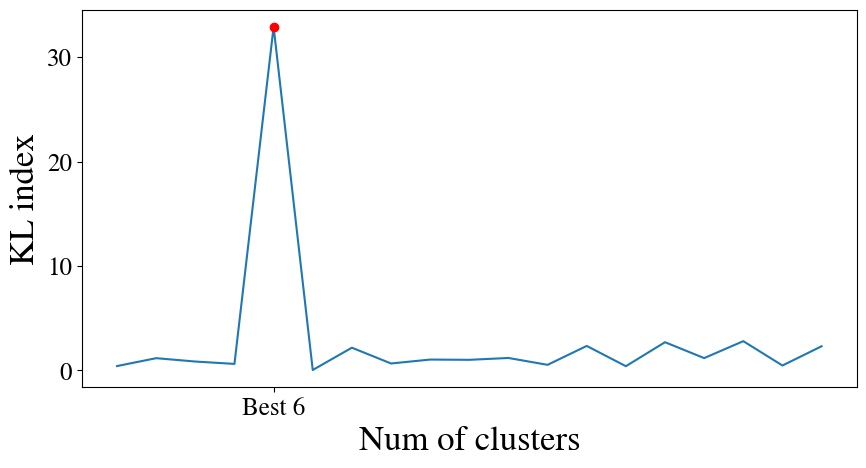

In [9]:
X = sing_vals_both_pool_normed
# kl, hartigan, marriot, tracew
# load fn in R  (I tried this Mar 22, 2023) 
r.library("NbClust")
NbClust_R = r["NbClust"]
nclus_range = [2, 20]
res = NbClust_R(X, 
                min_nc=nclus_range[0], 
                max_nc=nclus_range[1], 
                method="kmeans", 
                index="kl")
clu_res = dict(res.items())
clu_res= edict(clu_res)

# get the results
n_clus_best = int(clu_res["Best.nc"][0])
labs_best = clu_res["Best.partition"]-1 
kl_vals = clu_res['All.index']
cens_best = []
for ix in range(n_clus_best):
    cen = np.mean(X[labs_best==ix], axis=0)
    cens_best.append(cen)
cens_best = np.array(cens_best)

plt.plot(np.arange(nclus_range[0], nclus_range[1]+1), kl_vals)
plt.plot(n_clus_best, np.max(clu_res["All.index"]), "or")
plt.xticks([n_clus_best], [f"Best {n_clus_best}"])
plt.xlabel("Num of clusters")
plt.ylabel("KL index")

#### AD vs Ctrl in clustering

In [10]:
num_segs_ctrl = sing_vals_ctrls_pool.shape[0]
num_segs_AD = sing_vals_ADs_pool.shape[0]
labs_ctrl = labs_best[:num_segs_ctrl]
labs_AD = labs_best[num_segs_ctrl:]

tmp = np.unique(labs_AD, return_counts=True)
cnts_AD = np.array([tmp[1][tmp[0]==ix][0] for ix in range(n_clus_best)])
tmp = np.unique(labs_ctrl, return_counts=True)
cnts_ctrl = np.array([tmp[1][tmp[0]==ix][0] for ix in range(n_clus_best)])

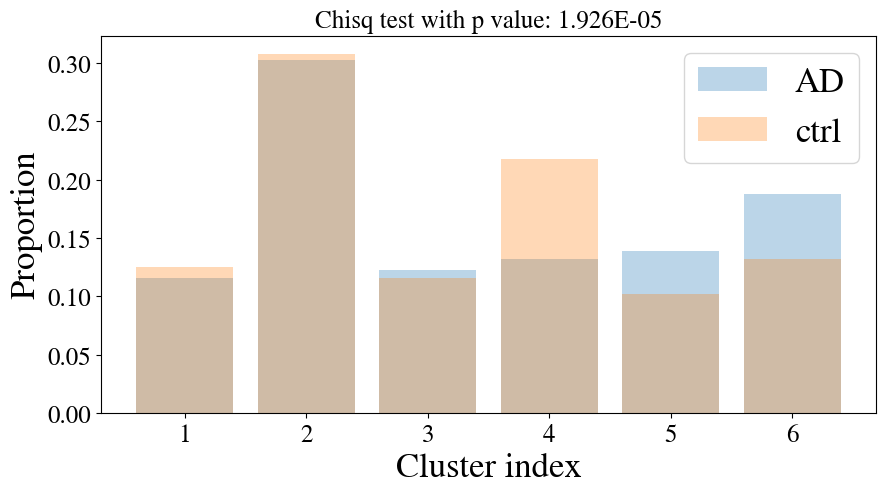

In [198]:
# chisq test 
res = scipy.stats.chi2_contingency(np.stack([cnts_ctrl, cnts_AD]))
plt.title(f"Chisq test with p value: {res[1]:.3E}")
plt.bar(list(range(1, n_clus_best+1)), cnts_AD/cnts_AD.sum(), alpha=0.3, label="AD")
plt.bar(list(range(1, n_clus_best+1)), cnts_ctrl/cnts_ctrl.sum(), alpha=0.3, label="ctrl")
plt.xlabel("Cluster index")
plt.ylabel("Proportion")
plt.legend()
plt.savefig(FIG_ROOT/f"bar_plot_nclu{n_clus_best}.jpg")

##### transition matrix

In [14]:
# Get transition matrix for ctrl and AD 

# update the count transited from one state to another. 
def update_trans_cnt(cur_trans, vec):
    for ix in range(len(vec)-1):
        from_ = vec[ix]
        to_ = vec[ix+1]
        cur_trans[from_, to_] += 1
    return cur_trans

# AD
flag = 0
labs_eachdata_AD = []
for cur_v in cur_res.singular_vals_ADs:
    n_ele = cur_v.shape[1]
    labs_eachdata_AD.append(labs_AD[flag:(flag+n_ele)])
    flag += n_ele
    
trans_AD = np.zeros((n_clus_best, n_clus_best))
for ix in range(len(labs_eachdata_AD)):
    cur_vec = labs_eachdata_AD[ix]
    trans_AD = update_trans_cnt(trans_AD, cur_vec)
    
# ctrl
flag = 0
labs_eachdata_ctrl = []
for cur_v in cur_res.singular_vals_ctrls:
    n_ele = cur_v.shape[1]
    labs_eachdata_ctrl.append(labs_ctrl[flag:(flag+n_ele)])
    flag += n_ele
    
trans_ctrl = np.zeros((n_clus_best, n_clus_best))
for ix in range(len(labs_eachdata_ctrl)):
    cur_vec = labs_eachdata_ctrl[ix]
    trans_ctrl = update_trans_cnt(trans_ctrl, cur_vec)
    

In [17]:
non_diag_mask = ~np.eye(n_clus_best,dtype=bool)
cut_v = np.median(np.concatenate([trans_AD[non_diag_mask], trans_ctrl[non_diag_mask]]))
np.savetxt(f"../../mid_results/chord_plot_kmeans_{n_clus_best}_AD.txt", trans_AD)
np.savetxt(f"../../mid_results/chord_plot_kmeans_{n_clus_best}_Ctrl.txt", trans_ctrl)
print(f"cut_v is {cut_v}")

cut_v is 12.0


In [18]:
# stationery probs
P_AD = trans_AD/trans_AD.sum(axis=1, keepdims=True)
pis_AD = np.linalg.eig(P_AD.T)[1][:, 0]
pis_AD = np.abs(pis_AD/pis_AD.sum())
P_ctrl = trans_ctrl/trans_ctrl.sum(axis=1, keepdims=True)
pis_ctrl = np.linalg.eig(P_ctrl.T)[1][:, 0]
pis_ctrl = np.abs(pis_ctrl/pis_ctrl.sum())

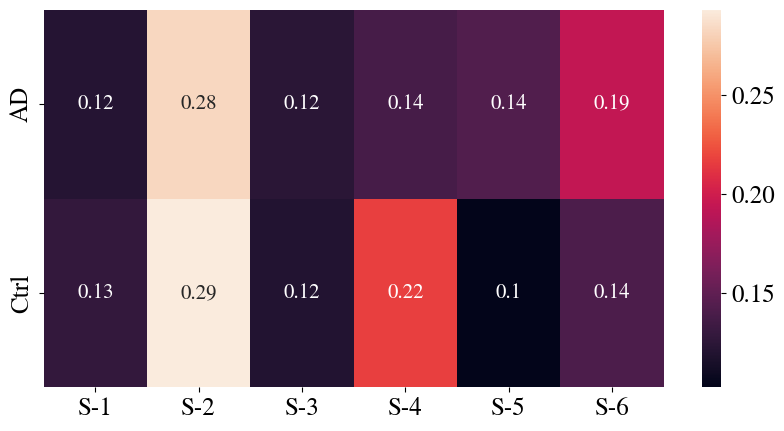

In [91]:
sns.heatmap([pis_AD, pis_ctrl], annot=True)
plt.yticks([0.5, 1.5], ["AD", "Ctrl"])
plt.xticks(np.arange(n_clus_best)+0.5, [f"S-{iz}" for iz in range(1, n_clus_best+1)]);

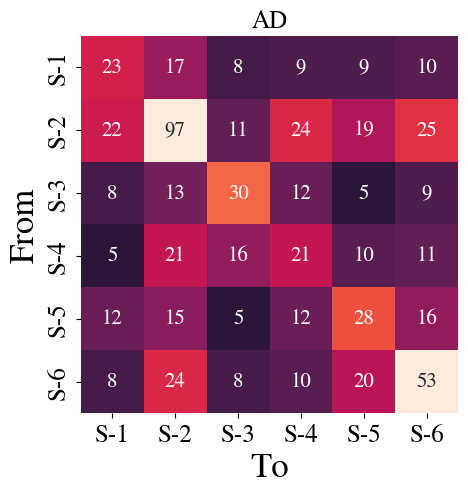

In [232]:
max_v = np.max(np.concatenate([trans_AD[non_diag_mask], trans_ctrl[non_diag_mask]]))
#sns.heatmap(P_AD, annot=True, square=True, cbar=False, vmin=0, vmax=0.5)
sns.heatmap(trans_AD, annot=True, square=True, cbar=False, vmin=0, vmax=max_v)
plt.yticks(np.arange(n_clus_best)+0.5, [f"S-{iz}" for iz in range(1, n_clus_best+1)])
plt.xticks(np.arange(n_clus_best)+0.5, [f"S-{iz}" for iz in range(1, n_clus_best+1)])
plt.ylabel("From")
plt.xlabel("To")
plt.title("AD")
plt.savefig(FIG_ROOT/f"trans_mat_AD_{n_clus_best}.jpg")

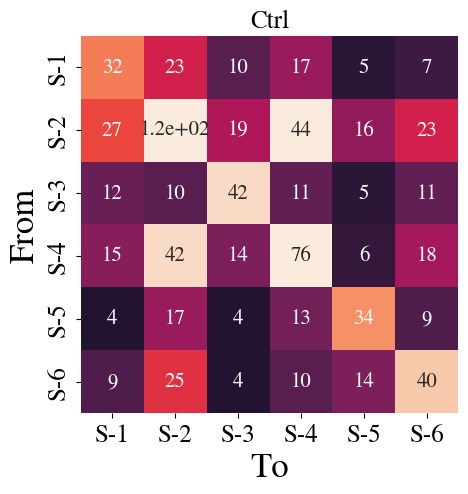

In [233]:
#sns.heatmap(P_ctrl, annot=True, square=True, cbar=False, vmin=0, vmax=0.5)
sns.heatmap(trans_ctrl, annot=True, square=True, cbar=False, vmin=0, vmax=max_v)
plt.yticks(np.arange(n_clus_best)+0.5, [f"S-{iz}" for iz in range(1, n_clus_best+1)])
plt.xticks(np.arange(n_clus_best)+0.5, [f"S-{iz}" for iz in range(1, n_clus_best+1)])
plt.ylabel("From")
plt.xlabel("To")
plt.title("Ctrl")
plt.savefig(FIG_ROOT/f"trans_mat_ctrl_{n_clus_best}.jpg")

In [212]:
### Permutation test
# we assess the difference between two matrices, note that we 
# should remove the effects of the total num of transitions
#trans_diff_fn = (lambda mats: mats[0]/mats[0].sum()
#                 -mats[1]/mats[1].sum())
#trans_diff_fn = (lambda mats: mats[0]/mats[0].sum(axis=1, keepdims=True)
#                 -mats[1]/mats[1].sum(axis=1, keepdims=True))
trans_diff_fn = lambda mats: mats[0]-mats[1]
trans_diff_obs = trans_diff_fn([trans_AD, trans_ctrl])
labs_eachdata_both = labs_eachdata_ctrl + labs_eachdata_AD
num_perm = 10000

trans_diffs_perm = []
for iy in trange(num_perm):
    AD_idxs_perm = np.sort(np.random.choice(len(labs_eachdata_both), size=len(labs_eachdata_AD), replace=False))
    labs_eachdata_AD_perm = [labs_eachdata_both[ix] for ix in AD_idxs_perm]
    labs_eachdata_ctrl_perm = [labs_eachdata_both[ix] 
                               for ix in range(len(labs_eachdata_both))
                               if ix not in AD_idxs_perm]
    
    trans_AD_perm = np.zeros((n_clus_best, n_clus_best))
    for ix in range(len(labs_eachdata_AD_perm)):
        cur_vec = labs_eachdata_AD_perm[ix]
        trans_AD_perm = update_trans_cnt(trans_AD_perm, cur_vec)
        
    trans_ctrl_perm = np.zeros((n_clus_best, n_clus_best))
    for ix in range(len(labs_eachdata_ctrl_perm)):
        cur_vec = labs_eachdata_ctrl_perm[ix]
        trans_ctrl_perm = update_trans_cnt(trans_ctrl_perm, cur_vec)
        
    trans_diffs_perm.append(trans_diff_fn([trans_AD_perm, trans_ctrl_perm]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 968.66it/s]


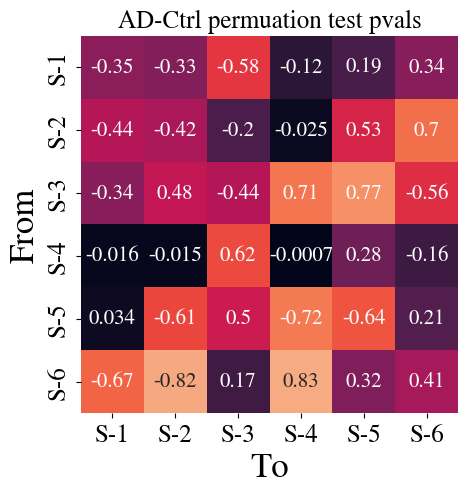

In [214]:
pval_mat = (np.abs(trans_diffs_perm) >  np.abs(trans_diff_obs[np.newaxis])).mean(axis=0)
mask_mat = np.ones_like(pval_mat)
mask_mat[trans_diff_obs < 0] = -1
plot_mat = mask_mat * pval_mat
sns.heatmap(pval_mat, annot=plot_mat, square=True, cbar=False, vmin=0, vmax=1)
plt.yticks(np.arange(n_clus_best)+0.5, [f"S-{iz}" for iz in range(1, n_clus_best+1)])
plt.xticks(np.arange(n_clus_best)+0.5, [f"S-{iz}" for iz in range(1, n_clus_best+1)])
plt.ylabel("From")
plt.xlabel("To")
plt.title("AD-Ctrl permuation test pvals")
plt.savefig(FIG_ROOT/f"wU_cluster{n_clus_best}_perm_entrywise.jpg")

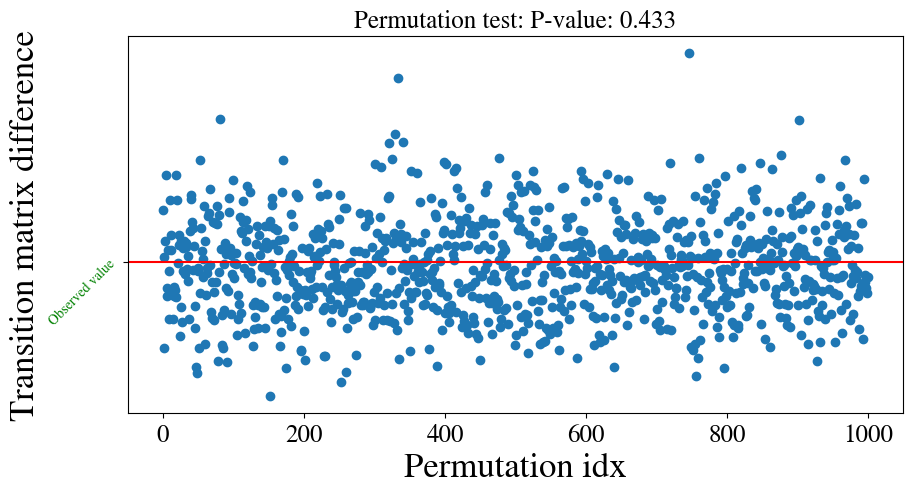

In [26]:
# permuation test for the all mat (do not need it now Mar 23, 2023)
plt.plot(trans_diffs_perm, "o")
plt.axhline(trans_diff_obs, color="red")
plt.ylabel("Transition matrix difference")
plt.xlabel("Permutation idx")
pval = np.mean(np.array(trans_diffs_perm)>trans_diff_obs)
plt.yticks([trans_diff_obs], ["Observed value"], fontsize=10, rotation=45, color="green")
plt.title(f"Permutation test: P-value: {pval:.3f}")
plt.savefig(FIG_ROOT/f"wU_cluster{n_clus_best}_perm.jpg")

##### draw chord plot

(from Mar 16, 2023, I use R to plot chord )

In [33]:
def mat2df(mat, include_diag=False, no_zero=True, cut_off=None):
    source = np.repeat(list(range(1, 1+n_clus)), n_clus)
    target = np.repeat(np.arange(1,1+n_clus).reshape(1,-1), n_clus, axis=0).reshape(-1)
    value = mat.flatten()
    idxs = source !=-100
    if not include_diag:
        idxs = np.bitwise_and(idxs, source != target)
    if no_zero:
        idxs = np.bitwise_and(idxs, value!=0)
    if cut_off is not None:
        idxs = np.bitwise_and(idxs, value>cut_off)
    source = source[idxs]
    target = target[idxs]
    value = value[idxs]
    res_df = pd.DataFrame({
        "source": source, 
        "target": target, 
        "value": value.astype(int)
    })
    return res_df

non_diag_mask = ~np.eye(n_clus,dtype=bool)
cut_v = np.median(np.concatenate([trans_AD[non_diag_mask], trans_ctrl[non_diag_mask]]))
nodes = pd.DataFrame({
    "index": list(range(1, n_clus+1)),
    "name": [f"State {ix}" for ix in range(1, n_clus+1)]
})
nodes = hv.Dataset(nodes, "index")

In [34]:
# AD (from Mar 16, 2023, I use R to plot chord )
chord_data = mat2df(trans_AD, cut_off=cut_v)
chord = hv.Chord((chord_data, nodes))
chord.opts(cmap='Category20', labels='name', 
           title="AD", fontsize=20, 
           zrotation=45,
           edge_color=dim('source').str(), 
           node_color=dim("index").str())
rendered_plot = hv.render(chord)
#rendered_plot.savefig(FIG_ROOT/f"chordAD_nclu{n_clus}.jpg")

# ctrl
chord_data = mat2df(trans_ctrl, cut_off=cut_v)
chord = hv.Chord((chord_data, nodes))
chord.opts(cmap='Category20', labels='name', 
           title="Ctrl", fontsize=20, 
           zrotation=45,
           edge_color=dim('source').str(), 
           node_color=dim("index").str())
rendered_plot = hv.render(chord)
rendered_plot.savefig(FIG_ROOT/f"chordctrl_nclu{n_clus}.jpg")

### Transition on U

In [62]:
labs_U_AD = [np.argmax(np.abs(singular_vals), axis=0) 
             for singular_vals in cur_res.singular_vals_ADs]
labs_U_ctrl = [np.argmax(np.abs(singular_vals), axis=0) 
             for singular_vals in cur_res.singular_vals_ctrls]

In [63]:
trans_U_AD = np.zeros((20, 20))
for ix in range(len(labs_U_AD)):
    cur_vec = labs_U_AD[ix]
    trans_U_AD = update_trans_cnt(trans_U_AD, cur_vec)
    
trans_U_ctrl = np.zeros((20, 20))
for ix in range(len(labs_U_ctrl)):
    cur_vec = labs_U_ctrl[ix]
    trans_U_ctrl = update_trans_cnt(trans_U_ctrl, cur_vec)
    
np.savetxt(f"../../mid_results/chord_plot_U_AD.txt", trans_U_AD)
np.savetxt(f"../../mid_results/chord_plot_U_Ctrl.txt", trans_U_ctrl)

In [64]:
### Permutation test
# we assess the difference between two matrices, note that we 
# should remove the effects of the total num of transitions
trans_diff_fn = (lambda mats: mats[0]/mats[0].sum()
                 -mats[1]/mats[1].sum())
#trans_diff_fn = (lambda mats: mats[0]/mats[0].sum(axis=1, keepdims=True)
#                 -mats[1]/mats[1].sum(axis=1, keepdims=True))
trans_diff_fn = lambda mats: mats[0]-mats[1]
trans_diff_U_obs = trans_diff_fn([trans_U_AD, trans_U_ctrl])
labs_U_both = labs_U_ctrl + labs_U_AD
num_perm = 1000

trans_diffs_U_perm = []
for iy in trange(num_perm):
    AD_idxs_perm = np.sort(np.random.choice(len(labs_U_both), size=len(labs_U_AD), replace=False))
    labs_U_AD_perm = [labs_U_both[ix] for ix in AD_idxs_perm]
    labs_U_ctrl_perm = [labs_U_both[ix] 
                               for ix in range(len(labs_U_both))
                               if ix not in AD_idxs_perm]
    
    trans_U_AD_perm = np.zeros((20, 20))
    for ix in range(len(labs_U_AD_perm)):
        cur_vec = labs_U_AD_perm[ix]
        trans_U_AD_perm = update_trans_cnt(trans_U_AD_perm, cur_vec)
        
    trans_U_ctrl_perm = np.zeros((20, 20))
    for ix in range(len(labs_U_ctrl_perm)):
        cur_vec = labs_U_ctrl_perm[ix]
        trans_U_ctrl_perm = update_trans_cnt(trans_U_ctrl_perm, cur_vec)
        
    trans_diffs_U_perm.append(trans_diff_fn([trans_U_AD_perm, trans_U_ctrl_perm]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 940.03it/s]


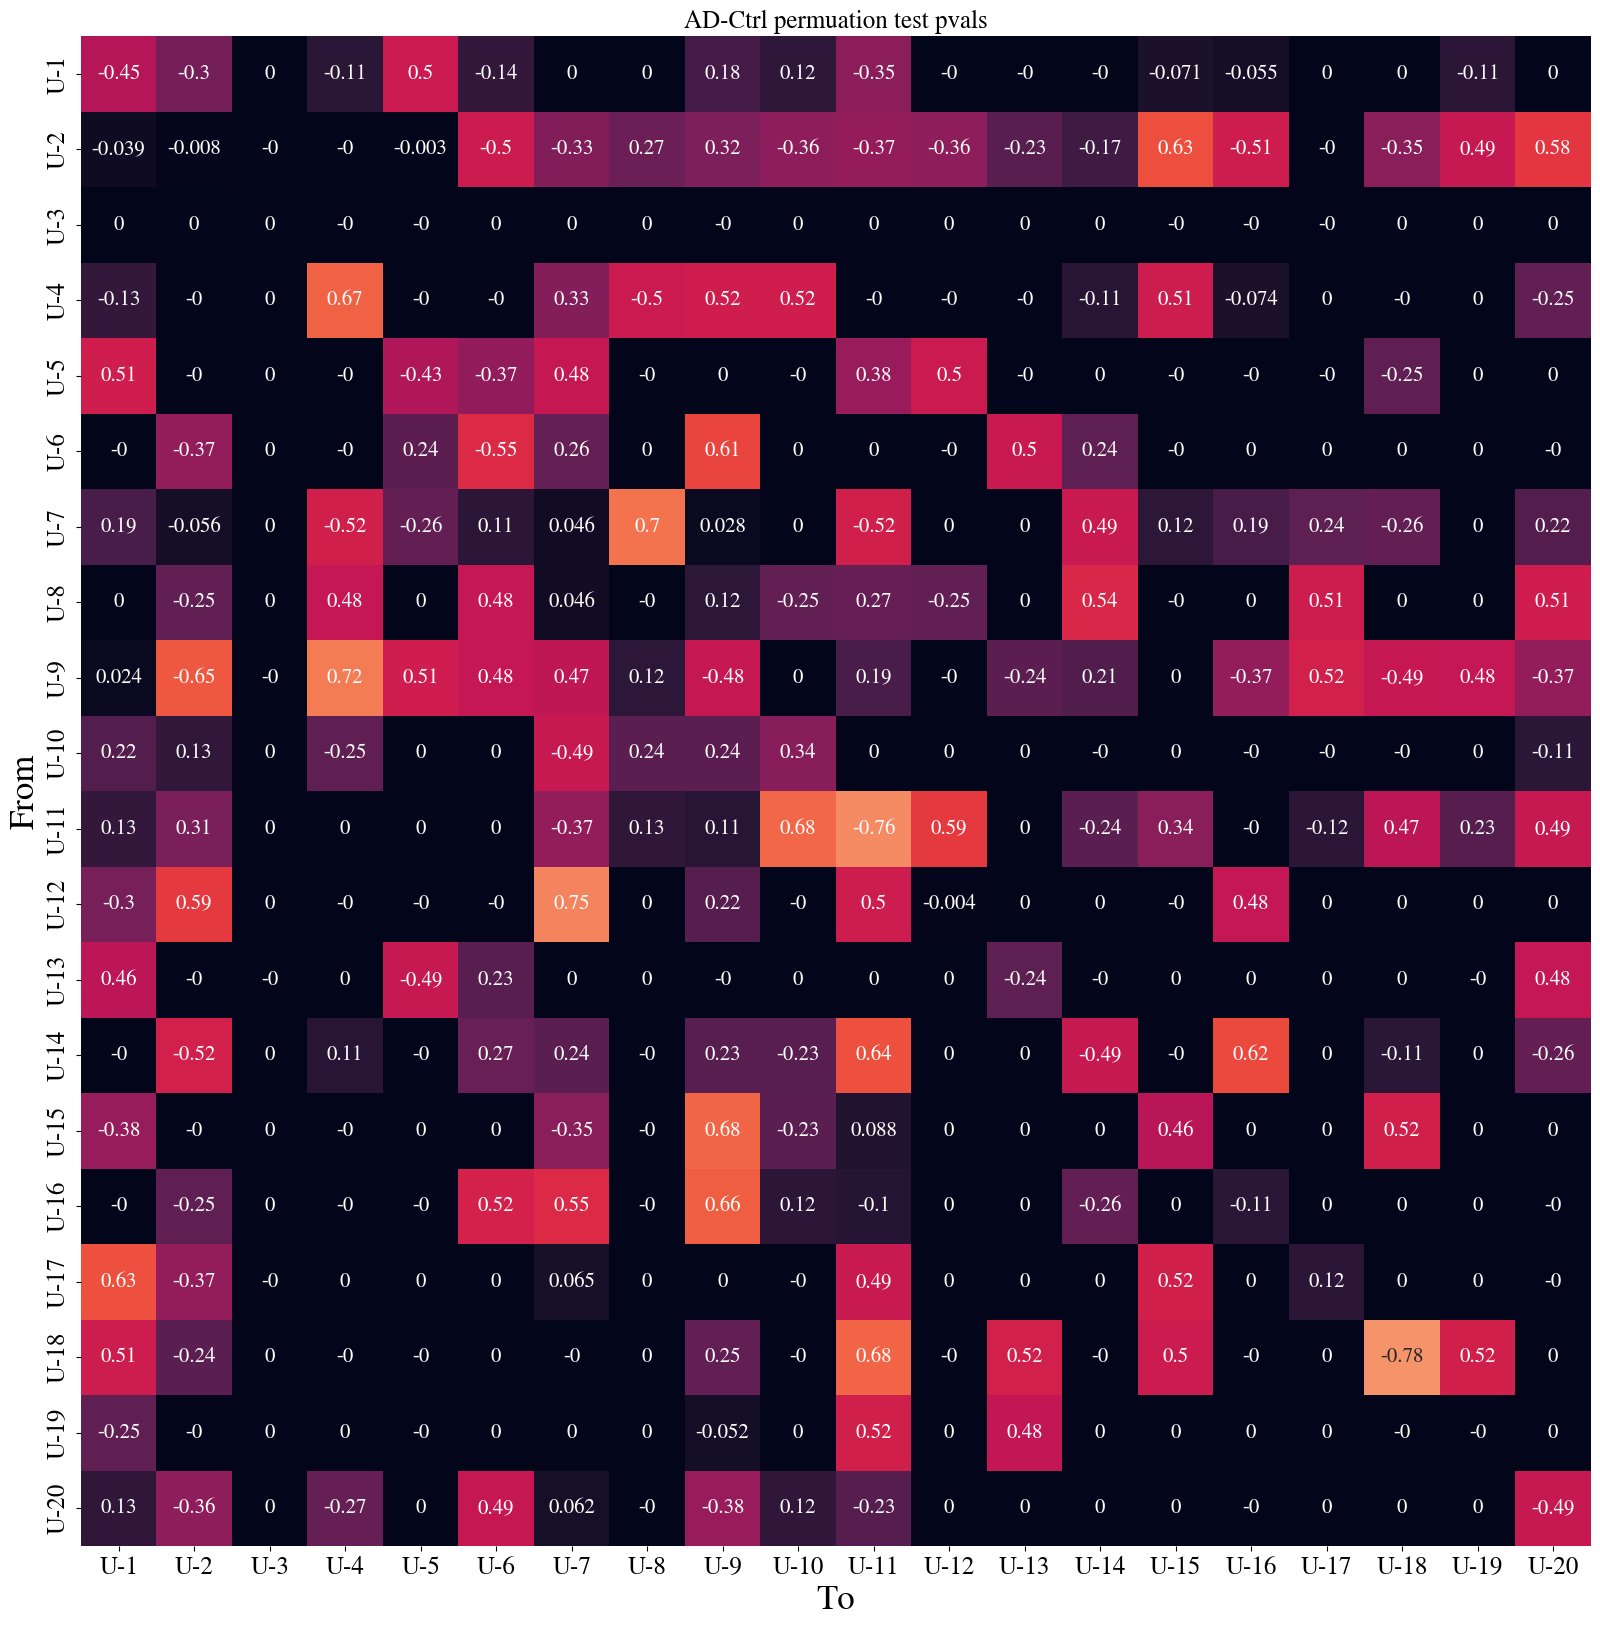

In [67]:
num_U = 20
pval_mat = (np.abs(trans_diffs_U_perm) >  np.abs(trans_diff_U_obs[np.newaxis])).mean(axis=0)
mask_mat = np.ones_like(pval_mat)
mask_mat[trans_diff_U_obs < 0] = -1
plot_mat = mask_mat * pval_mat
plt.figure(figsize=[20, 20])
sns.heatmap(pval_mat, annot=plot_mat, square=True, cbar=False, vmin=0, vmax=1)
plt.yticks(np.arange(num_U)+0.5, [f"U-{iz}" for iz in range(1, num_U+1)])
plt.xticks(np.arange(num_U)+0.5, [f"U-{iz}" for iz in range(1, num_U+1)])
plt.ylabel("From")
plt.xlabel("To")
plt.title("AD-Ctrl permuation test pvals")
plt.savefig(FIG_ROOT/f"U_perm_entrywise.jpg")

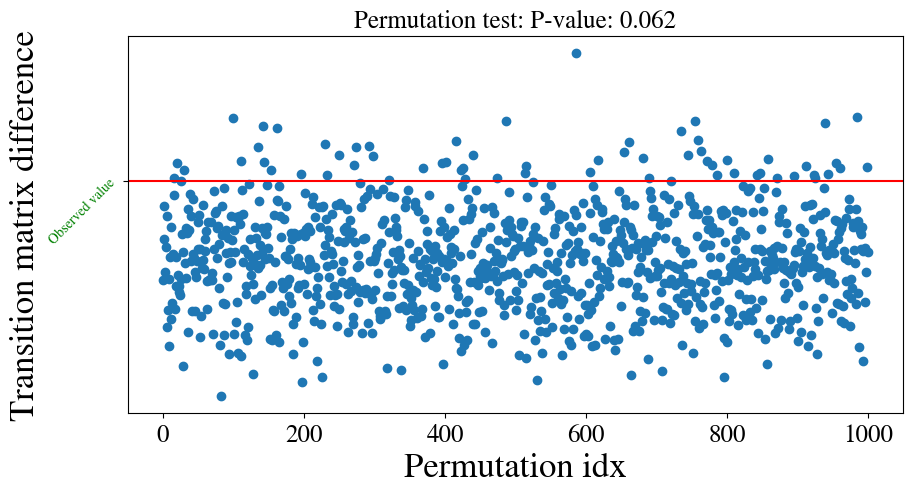

In [45]:
# permuation test for the all mat (do not need it now Mar 23, 2023)
plt.plot(trans_diffs_U_perm, "o")
plt.axhline(trans_diff_U_obs, color="red")
plt.ylabel("Transition matrix difference")
plt.xlabel("Permutation idx")
pval = np.mean(np.array(trans_diffs_U_perm)>trans_diff_U_obs)
plt.yticks([trans_diff_U_obs], ["Observed value"], fontsize=10, rotation=45, color="green")
plt.title(f"Permutation test: P-value: {pval:.3f}")
plt.savefig(FIG_ROOT/f"U_perm.jpg")

###  weighted U analysis

In [68]:
# I take abs of U and V (Mar 16, 2023)
U = np.abs(cur_res.CPDresult[0])
V = np.abs(cur_res.CPDresult[1])

#clu_cens = clus.cluster_centers_

In [152]:
# spec
from utils.misc import spec_emb_red

com_UVs = []
for ix in range(20):
    curU, curV = U[:, ix], V[:, ix]
    both_info = np.stack([curU, curV]).T
    com_UV = spec_emb_red(both_info)
    com_UVs.append(np.squeeze(com_UV))
com_UVs = np.array(com_UVs).T

wcom_UVs_abs = np.abs(com_UVs @ clu_cens.T)
wcom_UVs = com_UVs @ clu_cens.T
wUs_abs = np.abs(U @ clu_cens.T)
wVs_abs = np.abs(V @ clu_cens.T)
wUs = U @ clu_cens.T
wVs = V @ clu_cens.T

In [70]:
# clustering mean for each grp
clu_means_AD = []
clu_means_ctrl = []
for clu_idx in range(n_clus_best):
    clu_mean_AD = sing_vals_ADs_pool_normed[labs_AD==clu_idx].mean(axis=0)
    clu_mean_ctrl = sing_vals_ctrls_pool_normed[labs_ctrl==clu_idx].mean(axis=0)
    clu_means_AD.append(clu_mean_AD)
    clu_means_ctrl.append(clu_mean_ctrl)
    
clu_means_AD = np.array(clu_means_AD)
clu_means_ctrl = np.array(clu_means_ctrl)

wUs_AD = U @ clu_means_AD.T
wUs_ctrl = U @ clu_means_ctrl.T

In [72]:
# clustering mean for both grps
clu_means = []
for clu_idx in range(n_clus_best):
    clu_mean = sing_vals_both_pool_normed[labs_best==clu_idx].mean(axis=0)
    clu_means.append(clu_mean)
    
clu_means = np.array(clu_means)

wUs = U @ clu_means.T

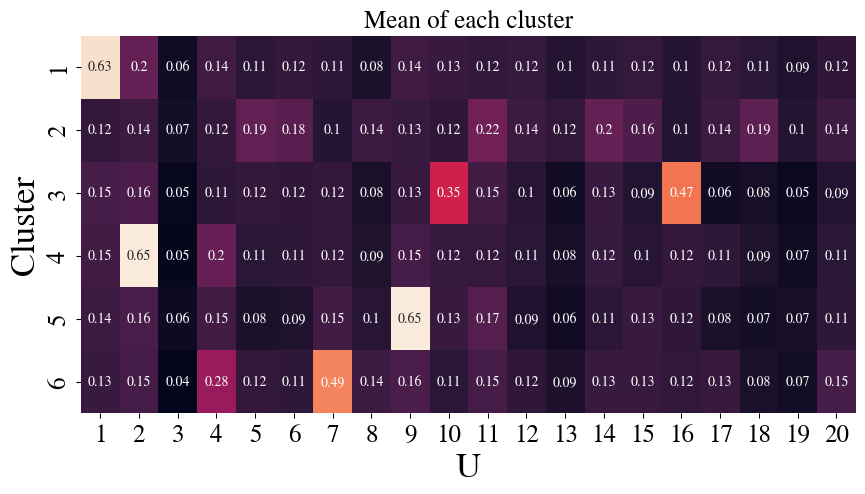

In [74]:
tmp = clu_means/clu_means.sum(axis=1, keepdims=True)
sns.heatmap(clu_means, annot=np.round(clu_means, 2), annot_kws={"size":10}, cbar=False)
plt.yticks(np.arange(n_clus_best)+0.5, list(range(1, n_clus_best+1)));
plt.xticks(np.arange(20)+0.5, list(range(1, 20+1)));
plt.xlabel("U")
plt.ylabel("Cluster")
plt.title("Mean of each cluster")
plt.savefig(FIG_ROOT/f"cluster_mean_{n_clus_best}.jpg")

#### corr with 7 connical nets

In [75]:
defNetsFil = list(DATA_ROOT.glob("DK_dic68.csv"))[0]
defNets = pd.read_csv(defNetsFil).T

DefNets_dict = {}
for ix in range(defNets.shape[-1]):
    curCol = defNets[ix]
    DefNets_dict[curCol[0]] = np.array(curCol[1:])
net_names = sorted(DefNets_dict.keys())

_paras.canon_nets = DefNets_dict
_paras.canon_net_names = net_names

In [76]:
# truncate small value in vec
def _cumsum_trunc(vec, cutoff=0.9):
    vec = vec.copy()
    idxs = cumsum_cutoff(vec, cutoff)
    counter_idxs = np.delete(np.arange(len(vec)), idxs)
    vec[counter_idxs] = 0
    return vec

# plot the corrmat with 7 canonical nets
def _corr_plot(vecs, cutoff=0.05, trun_fn=lambda x:x, trans_fn=np.abs):
    vecs = np.array(vecs)
    if vecs.shape[0] != 68:
        vecs = vecs.T
    assert vecs.shape[0] == 68
    corrMat = np.zeros((7, vecs.shape[-1]))
    for ix in range(vecs.shape[-1]):
        curU = vecs[:, ix]
        curU = trun_fn(curU)
        for iy, kz in enumerate(_paras.canon_net_names):
            curV = _paras.canon_nets[kz]
            curV = trun_fn(curV)
            corr_v, pv = scipy.stats.pearsonr(curU, curV)
            if pv <= cutoff:
                corrMat[iy, ix] = corr_v
            else:
                corrMat[iy, ix] = 0
            
    plt.figure(figsize=[15, 5])
    trans_corrMat = trans_fn(corrMat)
    sns.heatmap(trans_corrMat,  yticklabels=_paras.canon_net_names, 
                xticklabels=np.arange(1, vecs.shape[-1]+1),
                cmap="bwr", center=0, 
                vmin=-1, vmax=1, annot=np.round(trans_corrMat, 2))
    return corrMat

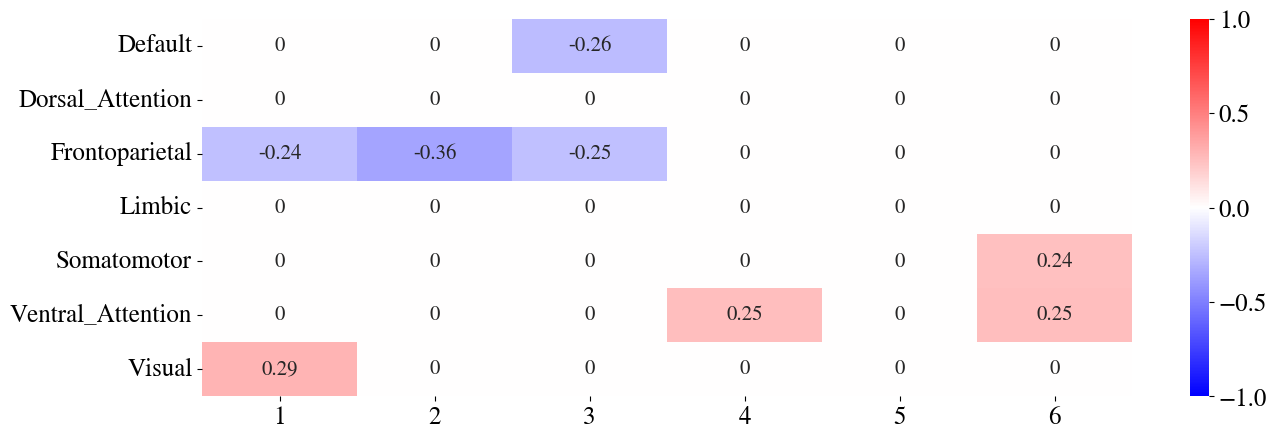

In [77]:
from functools import partial
tfn1 = partial(_cumsum_trunc, cutoff=1.95)
corr_mat = _corr_plot(wUs, cutoff=0.05, trun_fn=tfn1, trans_fn=lambda x:np.array(x));

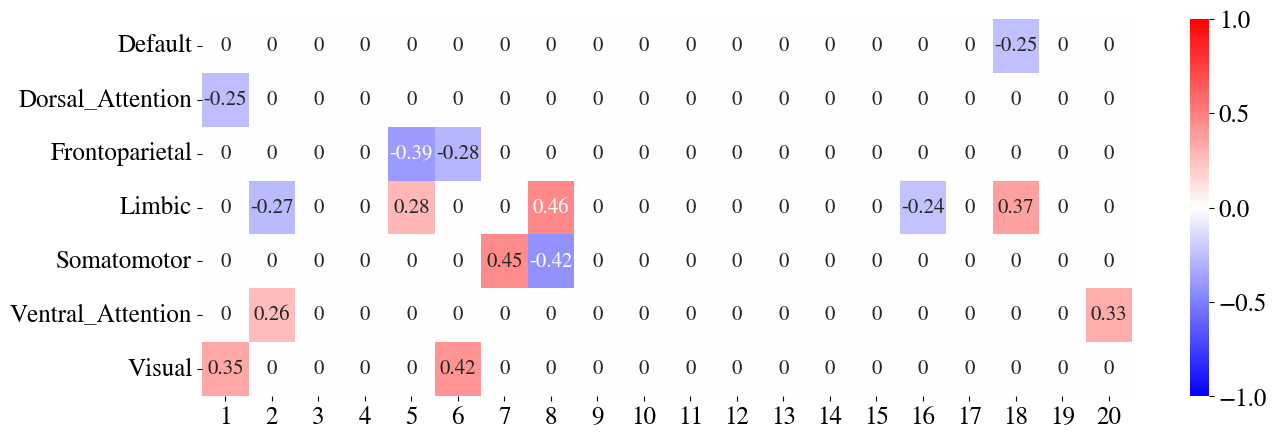

In [217]:
tfn1 = partial(_cumsum_trunc, cutoff=1.95)
corr_mat = _corr_plot(np.abs(U), cutoff=0.05, trun_fn=tfn1, trans_fn=lambda x:np.array(x));

#### Save

In [78]:
from constants import REGION_NAMES, REGION_NAMES_WLOBE
from utils.standardize import minmax_plotting, minmax_pn
from utils.brain_plot import reorder_U, U_2brain_vec, obt_FC_exp

# save the files for brainplotting
def save_brainplotting_vec(vecs, filname_prefix, order=2, is_csv=False):
    vecs = np.array(vecs)
    if vecs.shape[0] != 68:
        vecs = vecs.T
    for ix in range(vecs.shape[1]):
        cur_sing_vec = vecs[:, ix]
        out_vec_raw = minmax_plotting(cur_sing_vec, order=order)
        out_vec = U_2brain_vec(reorder_U(out_vec_raw))
        np.savetxt(RES_ROOT/f"./{filname_prefix}_{ix+1}.txt", out_vec)
        if is_csv:
            pd.DataFrame({"Name": REGION_NAMES,
                      "Vec": cur_sing_vec}).to_csv(RES_ROOT/f"./{filname_prefix}_{ix+1}.csv",
                                                          index=False)
# minmax a vec between [-1, 1]
def minmax_pn(x, order=1):
    num = 2 * (x-np.min(x))
    den = np.max(x) - np.min(x)
    res = num/den - 1
    res[res>0] = res[res>0]**order
    res[res<0] = -np.abs(res[res<0])**order
    return res

In [89]:
# save the DMN
DMN = np.array(defNets[0][1:])
out_vec = U_2brain_vec(reorder_U(DMN))
np.savetxt(RES_ROOT/f"./DMN.txt", out_vec)

In [80]:
dir_name = f"brain_vec_clu_{n_clus_best}"
if not (RES_ROOT/dir_name).exists():
    (RES_ROOT/dir_name).mkdir()

In [445]:
save_brainplotting_vec(np.array(U), f"m8_Us/m8_U_ord1", 1)
#save_brainplotting_vec(np.abs(U), f"m8_Us/m8_Uabs_ord1", 1)

In [81]:
save_brainplotting_vec(wUs, f"{dir_name}/m8_wU_ord2", 2)
save_brainplotting_vec(wUs_AD, f"{dir_name}/m8_spec_wUAD_ord2", 2)
save_brainplotting_vec(wUs_ctrl, f"{dir_name}/m8_spec_wUctrl_ord2", 2)

### Weights analysis

#### Unified weights

weights after CPD decomposition

In [59]:
# take abs of ws, Mar 16, 2023
ws_AD = np.abs(cur_res.CPDresult[2][88:])
ws_ctrl = np.abs(cur_res.CPDresult[2][:88])

# take abs and normalize vec for each subj such that L2 norm(vec) = 1
ws_normed_AD = np.abs(ws_AD)/np.linalg.norm(ws_AD, ord=2, axis=1, keepdims=True)
ws_normed_ctrl = np.abs(ws_ctrl)/np.linalg.norm(ws_ctrl, ord=2, axis=1, keepdims=True)

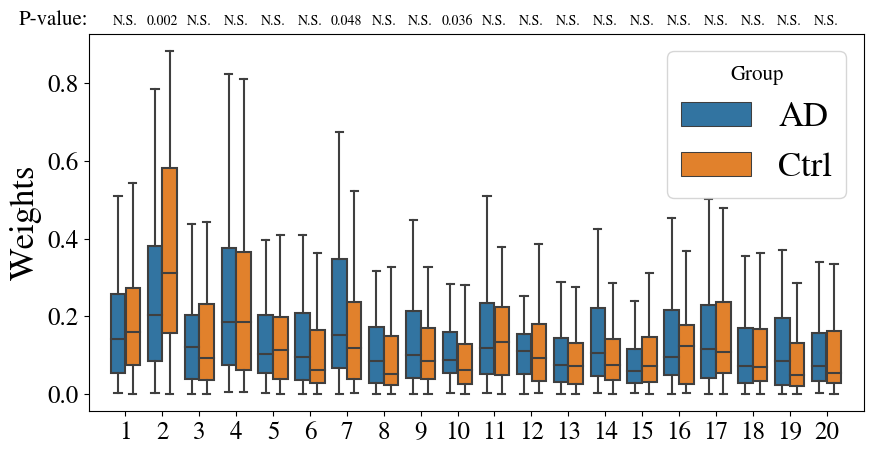

In [61]:
pvals = []
for ix in range(0, 20):
    AD_part = ws_normed_AD[:, ix]
    ctrl_part = ws_normed_ctrl[:, ix]
    test_res = scipy.stats.mannwhitneyu(AD_part, ctrl_part)
    pvals.append(test_res.pvalue)
    
df = pd.DataFrame({"Data": np.concatenate([ws_normed_AD.reshape(-1), ws_normed_ctrl.reshape(-1)]), 
                   "Group": ["AD"]*(88*20)+["Ctrl"]*(88*20), 
                   "EigenIdx": list(range(1, 21))* 88 +  list(range(1, 21))* 88
                                           })
sns.boxplot(data=df, y="Data", x="EigenIdx", hue="Group", showfliers=False)

plt.ylabel("Weights")
plt.xlabel("")
for ix in range(0, 20):
    if pvals[ix] <= 0.05:
        plt.text(ix, 0.95, f"{pvals[ix]:.3f}", ha="center", fontsize=10)
    else:
        plt.text(ix, 0.95, f"N.S.", ha="center", fontsize=10)
#plt.ylim([0, 400])
plt.xlim([-1, 20])
plt.text(-1, 0.95, "P-value:", ha="right")
plt.savefig(FIG_ROOT/"CP_ws_compare.jpg")

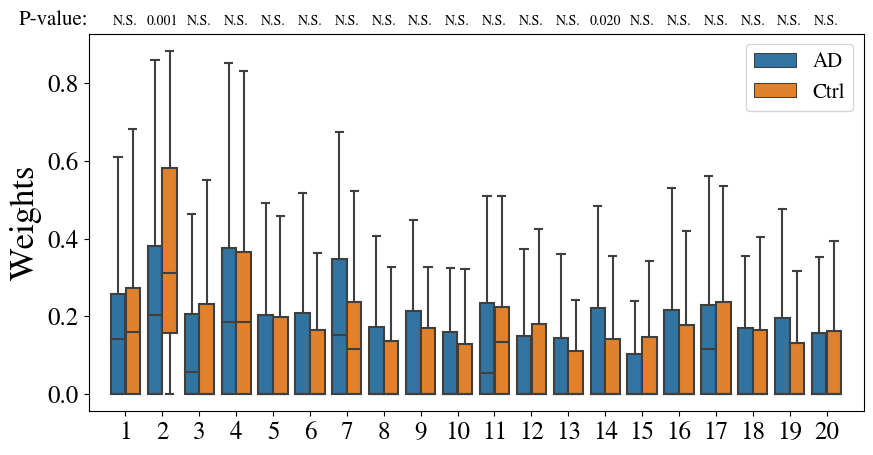

In [62]:
data = []
group = []
eigen_idx = []

for ix, sel_rank in enumerate(cur_res.sel_rank_ADs):
    ws = ws_normed_AD[ix].copy()
    group += ["AD"]*len(ws)
    eigen_idx += list(range(1, len(ws)+1))
    
    mask = np.ones(len(ws), dtype=bool)
    mask[sel_rank] = False
    ws[mask] = 0
    data += list(ws)
    
    
    
for ix, sel_rank in enumerate(cur_res.sel_rank_ctrls):
    ws = ws_normed_ctrl[ix].copy()
    group += ["Ctrl"]*len(ws)
    eigen_idx += list(range(1, len(ws)+1))
    
    mask = np.ones(len(ws), dtype=bool)
    mask[sel_rank] = False
    ws[mask] = 0
    data += list(ws)
    

df = pd.DataFrame({"Data": data,
                   "Group": group,
                   "EigenIdx": eigen_idx
                                           })

pvals = []
for ix in range(1, 21):
    AD_part = df[(df["Group"]=="AD") & (df["EigenIdx"]==ix)]["Data"]
    ctrl_part = df[(df["Group"]=="Ctrl") & (df["EigenIdx"]==ix)]["Data"]
    #test_res = ttest_ind(AD_part, ctrl_part, equal_var=False)
    test_res = mannwhitneyu(AD_part, ctrl_part)
    pvals.append(test_res.pvalue)
    
sns.boxplot(data=df, y="Data", x="EigenIdx", hue="Group", showfliers=False)
plt.legend(fontsize=15)
plt.ylabel("Weights")
plt.xlabel("")

text_h = 0.95
for ix in range(0, 20):
    if pvals[ix] <= 0.05:
        plt.text(ix, text_h, f"{pvals[ix]:.3f}", ha="center", fontsize=10)
    else:
        plt.text(ix, text_h, f"N.S.", ha="center", fontsize=10)
plt.xlim([-1, 20])
plt.text(-1, text_h, "P-value:", ha="right")
plt.savefig(FIG_ROOT/"CP_ws_rank_compare.jpg")

#### Reestimated weighted

- Detect

- Estimate the weight for each segment

- Pool all segments in each group together

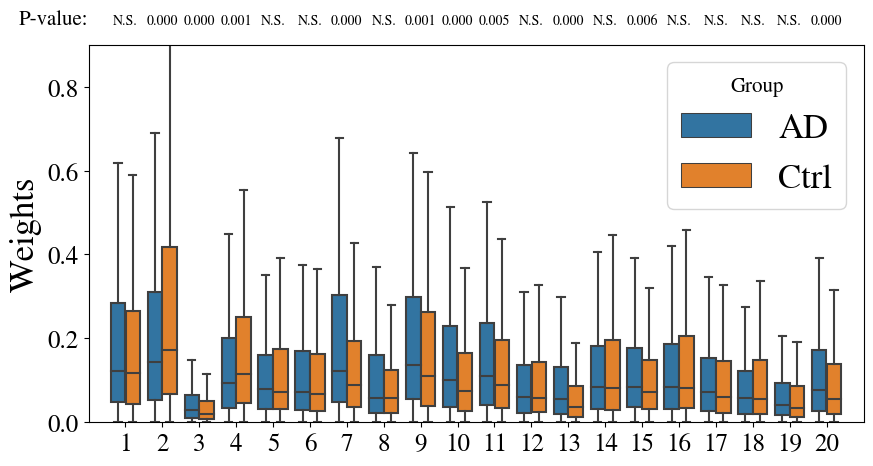

In [64]:

pvals = []
for ix in range(0, 20):
    AD_part = sing_vals_ADs_pool_normed[:, ix]
    ctrl_part = sing_vals_ctrls_pool_normed[:, ix]
    test_res = scipy.stats.mannwhitneyu(AD_part, ctrl_part)
    pvals.append(test_res.pvalue)
    
df = pd.DataFrame({"Data": np.concatenate([sing_vals_ADs_pool_normed.reshape(-1), 
                                           sing_vals_ctrls_pool_normed.reshape(-1)]), 
                   "Group": (["AD"]*(sing_vals_ADs_pool_normed.shape[0]*20)
                             +["Ctrl"]*(sing_vals_ctrls_pool_normed.shape[0]*20)), 
                   "EigenIdx": (list(range(1, 21))*sing_vals_ADs_pool_normed.shape[0] 
                                +  list(range(1, 21))*sing_vals_ctrls_pool_normed.shape[0])
                  })

sns.boxplot(data=df, y="Data", x="EigenIdx", hue="Group", showfliers=False)
plt.ylabel("Weights")
plt.xlabel("")
for ix in range(0, 20):
    if pvals[ix] <= 0.05:
        plt.text(ix, 0.95, f"{pvals[ix]:.3f}", ha="center", fontsize=10)
    else:
        plt.text(ix, 0.95, f"N.S.", ha="center", fontsize=10)
plt.ylim([0, 0.9])
plt.xlim([-1, 20])
plt.text(-1, 0.95, "P-value:", ha="right")
plt.savefig(FIG_ROOT/"Reestimate_ws_compare.jpg")

**Analysis on the maxdwell time**

In [119]:
sing_vals_raw = cur_res.singular_vals_ADs
dwells = cur_res.dwells_ADs_selected
sing_vals_maxdwell = []


for dwell, sing_vals in zip(dwells, sing_vals_raw):
    sing_vals_maxdwell.append(sing_vals[:, np.argmax(dwell)])
    
sing_vals_maxdwell = np.array(sing_vals_maxdwell)
sing_vals_maxdwell_normed = (np.abs(sing_vals_maxdwell)
                             /np.linalg.norm(sing_vals_maxdwell, axis=1, ord=2)[:, np.newaxis])
sing_vals_AD_maxdwell_normed = sing_vals_maxdwell_normed

In [120]:
sing_vals_raw = cur_res.singular_vals_ctrls
dwells = cur_res.dwells_ctrls_selected
sing_vals_maxdwell = []


for dwell, sing_vals in zip(dwells, sing_vals_raw):
    sing_vals_maxdwell.append(sing_vals[:, np.argmax(dwell)])
    
sing_vals_maxdwell = np.array(sing_vals_maxdwell)
sing_vals_maxdwell_normed = (np.abs(sing_vals_maxdwell)
                             /np.linalg.norm(sing_vals_maxdwell, axis=1, ord=2)[:, np.newaxis])
sing_vals_ctrl_maxdwell_normed = sing_vals_maxdwell_normed

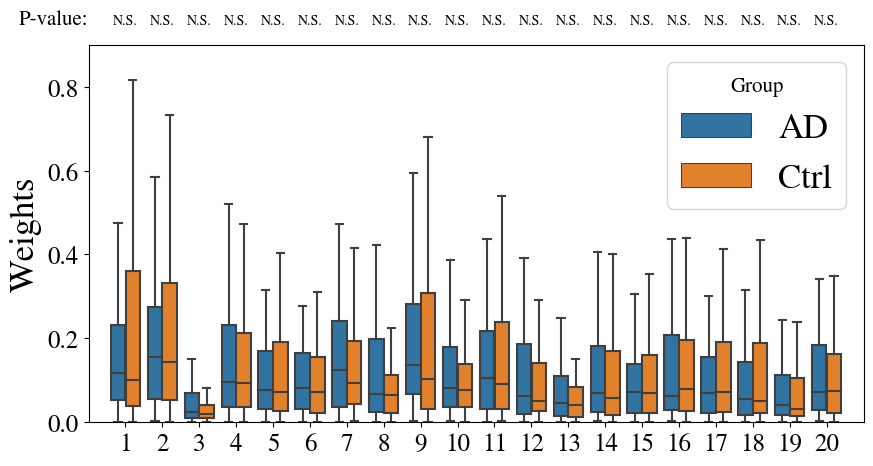

In [121]:
pvals = []
for ix in range(0, 20):
    AD_part = sing_vals_AD_maxdwell_normed[:, ix]
    ctrl_part = sing_vals_ctrl_maxdwell_normed[:, ix]
    test_res = scipy.stats.mannwhitneyu(AD_part, ctrl_part)
    pvals.append(test_res.pvalue)
    
df = pd.DataFrame({"Data": np.concatenate([sing_vals_AD_maxdwell_normed.reshape(-1), 
                                           sing_vals_ctrl_maxdwell_normed.reshape(-1)]), 
                   "Group": (["AD"]*(sing_vals_AD_maxdwell_normed.shape[0]*20)
                             +["Ctrl"]*(sing_vals_ctrl_maxdwell_normed.shape[0]*20)), 
                   "EigenIdx": (list(range(1, 21))*sing_vals_AD_maxdwell_normed.shape[0] 
                                +  list(range(1, 21))*sing_vals_ctrl_maxdwell_normed.shape[0])
                  })

sns.boxplot(data=df, y="Data", x="EigenIdx", hue="Group", showfliers=False)
plt.ylabel("Weights")
plt.xlabel("")
for ix in range(0, 20):
    if pvals[ix] <= 0.05:
        plt.text(ix, 0.95, f"{pvals[ix]:.3f}", ha="center", fontsize=10)
    else:
        plt.text(ix, 0.95, f"N.S.", ha="center", fontsize=10)
plt.ylim([0, 0.9])
plt.xlim([-1, 20])
plt.text(-1, 0.95, "P-value:", ha="right")
plt.savefig(FIG_ROOT/"Reestimate_ws_compare_maxdwell.jpg")

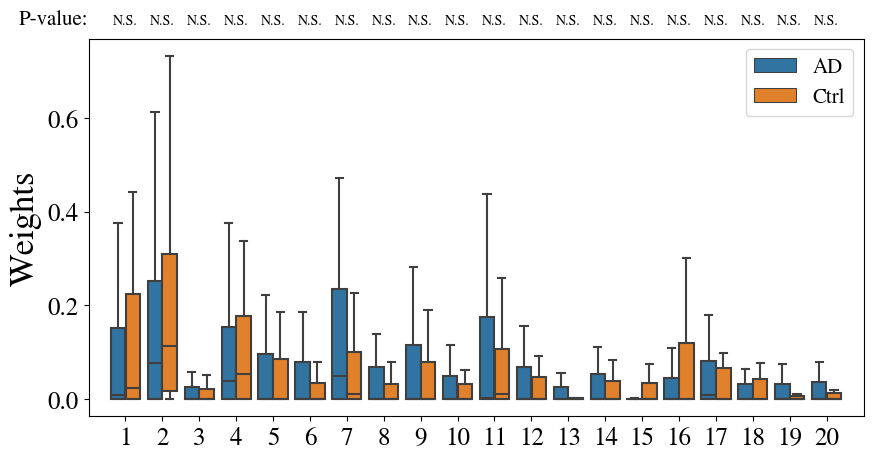

In [124]:
data = []
group = []
eigen_idx = []

for ix, sel_rank in enumerate(cur_res.sel_rank_ADs):
    ws = sing_vals_AD_maxdwell_normed[ix].copy()
    group += ["AD"]*len(ws)
    eigen_idx += list(range(1, len(ws)+1))
    
    mask = np.ones(len(ws), dtype=bool)
    mask[sel_rank] = False
    ws[mask] = 0
    data += list(ws)
    
    
    
for ix, sel_rank in enumerate(cur_res.sel_rank_ctrls):
    ws = sing_vals_ctrl_maxdwell_normed[ix].copy()
    group += ["Ctrl"]*len(ws)
    eigen_idx += list(range(1, len(ws)+1))
    
    mask = np.ones(len(ws), dtype=bool)
    mask[sel_rank] = False
    ws[mask] = 0
    data += list(ws)
    

df = pd.DataFrame({"Data": data,
                   "Group": group,
                   "EigenIdx": eigen_idx
                                           })

pvals = []
for ix in range(1, 21):
    AD_part = df[(df["Group"]=="AD") & (df["EigenIdx"]==ix)]["Data"]
    ctrl_part = df[(df["Group"]=="Ctrl") & (df["EigenIdx"]==ix)]["Data"]
    #test_res = ttest_ind(AD_part, ctrl_part, equal_var=False)
    test_res = mannwhitneyu(AD_part, ctrl_part)
    pvals.append(test_res.pvalue)
    
sns.boxplot(data=df, y="Data", x="EigenIdx", hue="Group", showfliers=False)
plt.legend(fontsize=15)
plt.ylabel("Weights")
plt.xlabel("")

text_h = 0.80
for ix in range(0, 20):
    if pvals[ix] <= 0.05:
        plt.text(ix, text_h, f"{pvals[ix]:.3f}", ha="center", fontsize=10)
    else:
        plt.text(ix, text_h, f"N.S.", ha="center", fontsize=10)
plt.xlim([-1, 20])
plt.text(-1, text_h, "P-value:", ha="right")
plt.savefig(FIG_ROOT/"Reestimate_ws_rank_compare_maxdwell.jpg")

### Spectral analysis

In [143]:
from scipy import signal

In [145]:
# the cpt is the last pt at the current segment
# it is from 1 not 0
sample_fs = 120
max_pt = 7200

def lam2lamfull(sing_vals, cpts, max_pt=7200):
    """This fn is to convert singular vals and cpts into a full seq 
    """
    cpts_full0 = np.concatenate([[-1], cpts-1, [max_pt-1]])
    nrow = sing_vals.shape[0]
    lam_full = np.zeros((nrow, max_pt))
    for ix in range(len(cpts_full0)-1):
        low, up = int(cpts_full0[ix]+1), int(cpts_full0[ix+1]+1)
        lam_full[:, low:up] = sing_vals[:, ix].reshape(-1, 1)
    return lam_full

#### PSD for U^T X

In [159]:
import mat73
datFil = list(DATA_ROOT.glob("70Ctrl*"))[0]
CtrlDat1 = loadmat(datFil)
CtrlDats = CtrlDat1["dk10"]
datFil = list(DATA_ROOT.glob("87AD*"))[0]
ADDat1 = loadmat(datFil)
ADDats = ADDat1["dk10"]
ADdatAdd = loadmat(DATA_ROOT/"DK_timecourse.mat")["DK_timecourse"]
CtrldatAdd = mat73.loadmat(DATA_ROOT/"timecourse_ucsfCONT_group.mat")["dk10"]

baseDF = pd.read_csv(DATA_ROOT/"AllDataBaselineOrdered.csv")
CtrlKp = np.array(baseDF[baseDF["Grp"]=="Ctrl"]["KeepIt"] == 1)
ADDatsAll = np.concatenate([ADDats, ADdatAdd[np.newaxis, :, :]], axis=0)
CtrlDatsAll = np.concatenate([CtrlDats, CtrldatAdd], axis=0)
CtrlDatsAll = CtrlDatsAll[CtrlKp]

In [230]:
#sample_fs = 120
#seqs_AD = np.sum(U[:, 1][np.newaxis, :, np.newaxis] * cur_res.dXXmats_AD[1], axis=1)
#seqs_ctrl = np.sum(U[:, 1][np.newaxis, :, np.newaxis] * cur_res.dXXmats_ctrl[1], axis=1)
sample_fs = 600
seqs_AD = np.sum(U[:, 1][np.newaxis, :, np.newaxis] * ADDatsAll, axis=1)
seqs_ctrl = np.sum(U[:, 1][np.newaxis, :, np.newaxis] * CtrlDatsAll, axis=1)

psds_AD = []
for seq in seqs_AD:
    f, psd = signal.welch(seq, fs=sample_fs, nperseg=256*5)
    psds_AD.append(psd)
psds_AD = np.array(psds_AD)
    
psds_ctrl = []
for seq in seqs_ctrl:
    f, psd = signal.welch(seq, fs=sample_fs, nperseg=256*5)
    psds_ctrl.append(psd)
psds_ctrl = np.array(psds_ctrl)

psds_ctrl_dB = np.log10(psds_ctrl)*10
psds_AD_dB = np.log10(psds_AD)*10

# only choose freq from [0, 40]
low_freq = 2
up_freq = 40
f_sub = f[np.bitwise_and(f>=low_freq, f<=up_freq)]
psds_AD_dB = psds_AD_dB[:, np.bitwise_and(f>=low_freq, f<=up_freq)]
psds_ctrl_dB = psds_ctrl_dB[:, np.bitwise_and(f>=low_freq, f<=up_freq)]

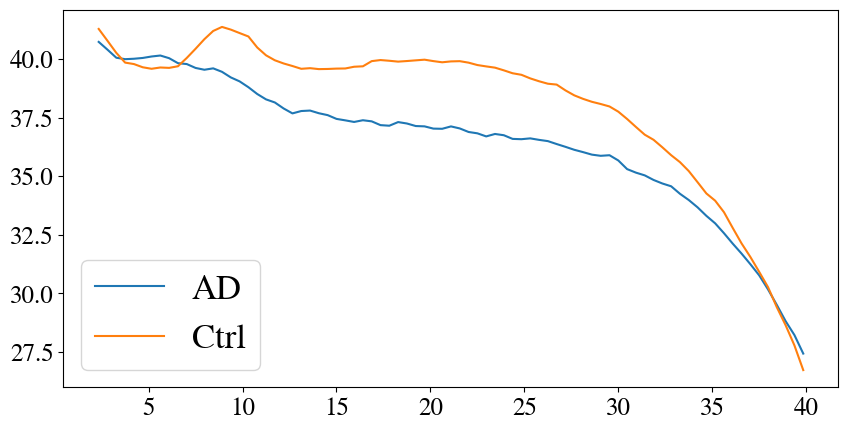

In [231]:
plt.plot(f_sub, psds_AD_dB.mean(axis=0), label="AD")
plt.plot(f_sub, psds_ctrl_dB.mean(axis=0), label="Ctrl")
plt.legend()

#### PSD

##### demo

In [87]:
# Take abs Mar 16, 2023
sing_vals = np.abs(cur_res.singular_vals_ADs[1])
cpts = cur_res.cpts_ADs_selected[1]

sing_vals_full = lam2lamfull(sing_vals, cpts)
psds_sing_val = []
for ix in range(sing_vals_full.shape[0]):
    f, psd = signal.welch(sing_vals_full[ix], fs=sample_fs, nperseg=256)
    psds_sing_val.append(psd)

f_sub = f[np.bitwise_and(f>=0, f<=35)]
psds_sing_val = np.array(psds_sing_val)[:, np.bitwise_and(f>=0, f<=35)]

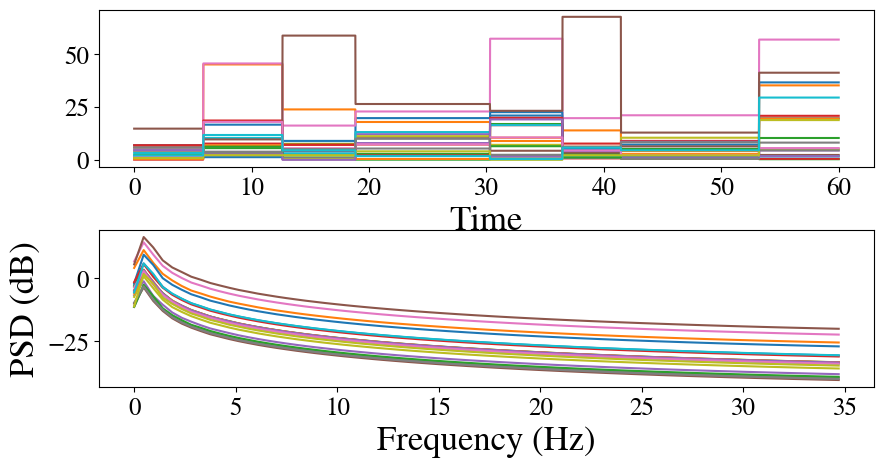

In [88]:
plt.subplot(211)
for ix in range(sing_vals_full.shape[0]):
    plt.plot(np.linspace(0, 60, max_pt), sing_vals_full[ix])
plt.xlabel("Time")
plt.subplot(212)
for ix in range(sing_vals_full.shape[0]):
    plt.plot(f_sub, 10*np.log10(psds_sing_val[ix]))
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (dB)")
plt.savefig(FIG_ROOT/"psd_demo.jpg")

##### PSD integration

In [89]:
f_sub = f[np.bitwise_and(f>=0, f<=35)]

In [90]:
psdss_sing_val_AD = []

for ix in range(88):
    # Take abs, Mar 16, 2023
    sing_vals = np.abs(cur_res.singular_vals_ADs[ix])
    cpts = cur_res.cpts_ADs_selected[ix]
    
    sing_vals_full = lam2lamfull(sing_vals, cpts)
    psds_sing_val = []
    for ix in range(sing_vals_full.shape[0]):
        f, psd = signal.welch(sing_vals_full[ix], fs=sample_fs, nperseg=256)
        psds_sing_val.append(psd)
    psdss_sing_val_AD.append(psds_sing_val)
    
psdss_sing_val_AD = np.array(psdss_sing_val_AD)[:, :, np.bitwise_and(f>=0, f<=35)]

In [91]:
psdss_sing_val_ctrl = []

for ix in range(88):
    # Take abs, Mar 16, 2023
    sing_vals = np.abs(cur_res.singular_vals_ctrls[ix])
    cpts = cur_res.cpts_ctrls_selected[ix]
    
    sing_vals_full = lam2lamfull(sing_vals, cpts)
    psds_sing_val = []
    for ix in range(sing_vals_full.shape[0]):
        f, psd = signal.welch(sing_vals_full[ix], fs=sample_fs, nperseg=256)
        psds_sing_val.append(psd)
    psdss_sing_val_ctrl.append(psds_sing_val)
    
psdss_sing_val_ctrl = np.array(psdss_sing_val_ctrl)[:, :, np.bitwise_and(f>=0, f<=35)]

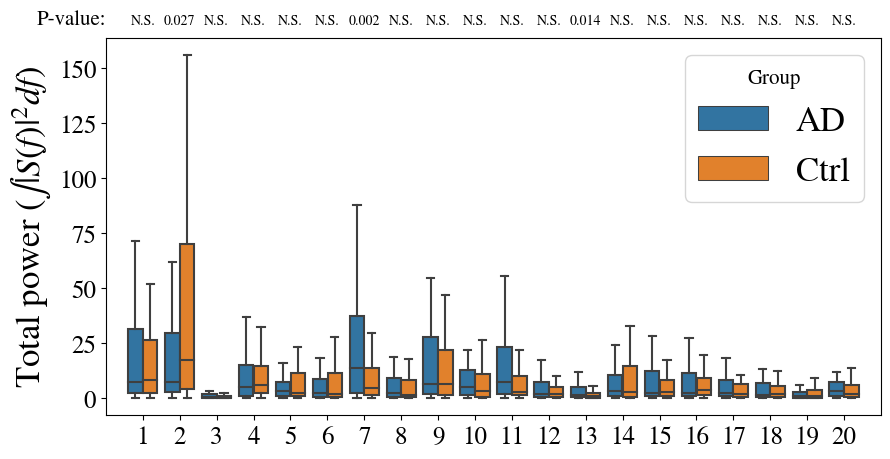

In [92]:
# \int_[0, 35] S(f) d f
psd_ints_AD = (psdss_sing_val_AD[:, :, :-1]* np.diff(f_sub)).sum(axis=-1)
psd_ints_ctrl = (psdss_sing_val_ctrl[:, :, :-1]* np.diff(f_sub)).sum(axis=-1)

df = pd.DataFrame({"Data": np.concatenate([psd_ints_AD.reshape(-1), psd_ints_ctrl.reshape(-1)]), 
                   "Group": ["AD"]*(88*20)+["Ctrl"]*(88*20), 
                   "EigenIdx": list(range(1, 21))* 88 +  list(range(1, 21))* 88
                                           })
pvals = []
for ix in range(1, 21):
    AD_part = df[(df["EigenIdx"]==ix) & (df["Group"]=="AD")]["Data"]
    ctrl_part = df[(df["EigenIdx"]==ix) & (df["Group"]=="Ctrl")]["Data"]
    test_res = scipy.stats.mannwhitneyu(AD_part, ctrl_part)
    pvals.append(test_res.pvalue)
    
sns.boxplot(data=df, y="Data", x="EigenIdx", hue="Group", showfliers=False)
#sns.violinplot(data=df, y="Data", x="EigenIdx", hue="Group", split=True)
plt.ylabel(r"Total power ($\int |S(f)|^2 d f$)")
plt.xlabel("")
text_h = 170
for ix in range(0, 20):
    if pvals[ix] <= 0.05:
        plt.text(ix, text_h, f"{pvals[ix]:.3f}", ha="center", fontsize=10)
    else:
        plt.text(ix, text_h, f"N.S.", ha="center", fontsize=10)
#plt.ylim([0, 400])
plt.xlim([-1, 20])
plt.text(-1, text_h, "P-value:", ha="right")
plt.savefig(FIG_ROOT/"PSD_power_compare.jpg")

Text(0.5, 0, 'Frequency (Hz)')

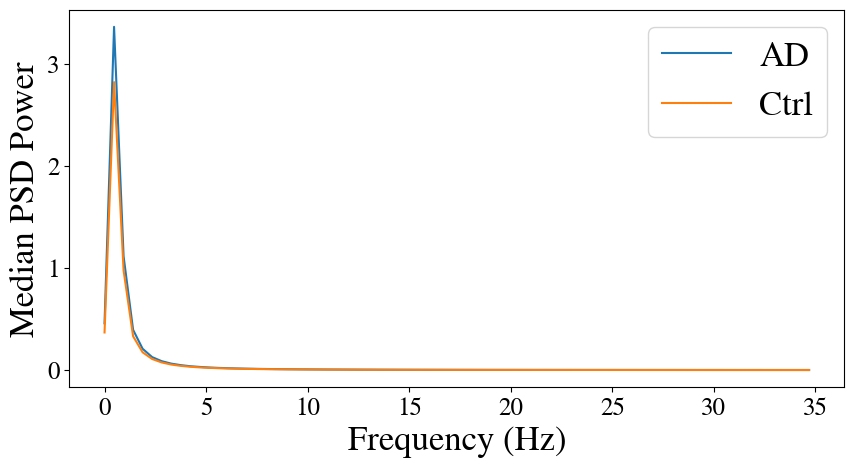

In [93]:
plt.plot(f_sub, np.median(psdss_sing_val_AD, axis=(0, 1)), label="AD")
plt.plot(f_sub, np.median(psdss_sing_val_ctrl, axis=(0, 1)), label="Ctrl")
plt.legend()
plt.ylabel("Median PSD Power")
plt.xlabel("Frequency (Hz)")

Text(0.5, 0, 'Frequency (Hz)')

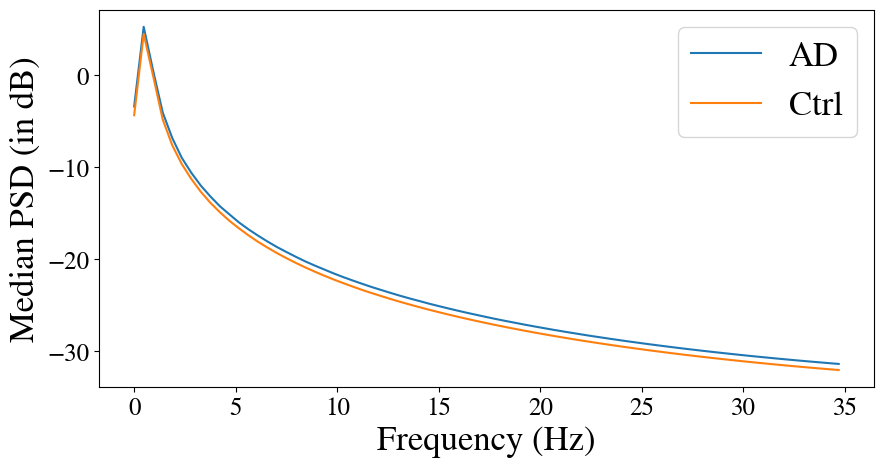

In [94]:
# Add a small number to avoid number
psdss_dB_sing_val_AD = 10 * np.log10(psdss_sing_val_AD + 1e-20)
psdss_dB_sing_val_ctrl = 10 * np.log10(psdss_sing_val_ctrl + 1e-20)

plt.plot(f_sub, np.median(psdss_dB_sing_val_AD, axis=(0, 1)), label="AD")
plt.plot(f_sub, np.median(psdss_dB_sing_val_ctrl, axis=(0, 1)), label="Ctrl")
plt.legend()
plt.ylabel("Median PSD (in dB)")
plt.xlabel("Frequency (Hz)")